# Benchmarking Our Algorithm against others

In [1]:
import sys
sys.path.append('../../')
import numpy as np

from panav.viz import draw_env,draw_hybrid
from panav.util import flowtime

import pickle as pkl

%load_ext autoreload
%autoreload 2

MultiTunnel


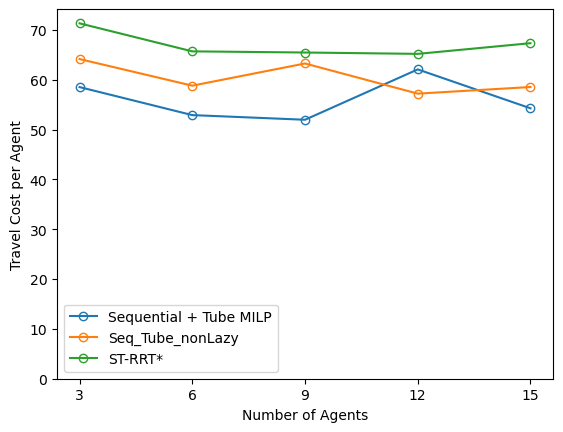

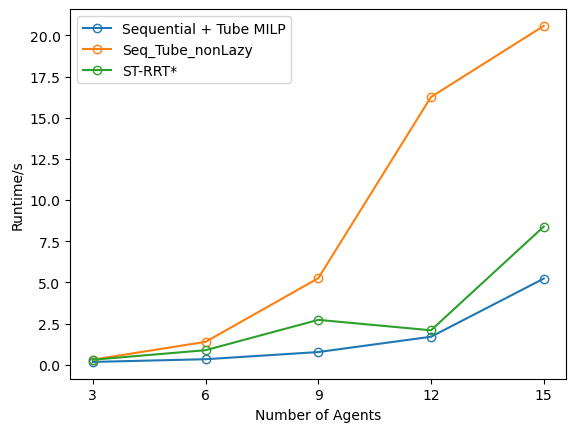

SingleTunnel


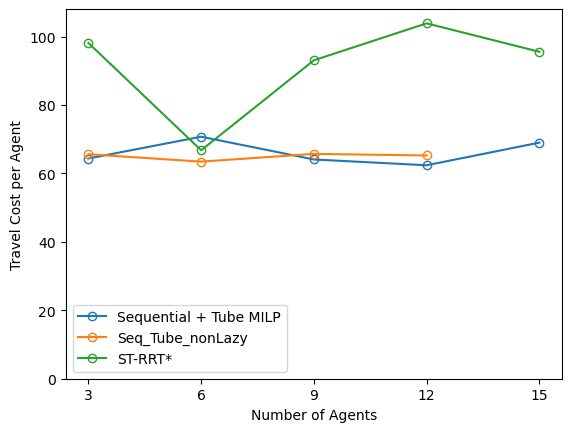

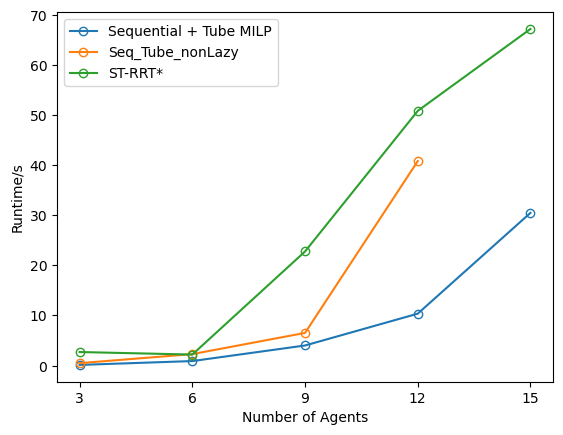

Warehouse


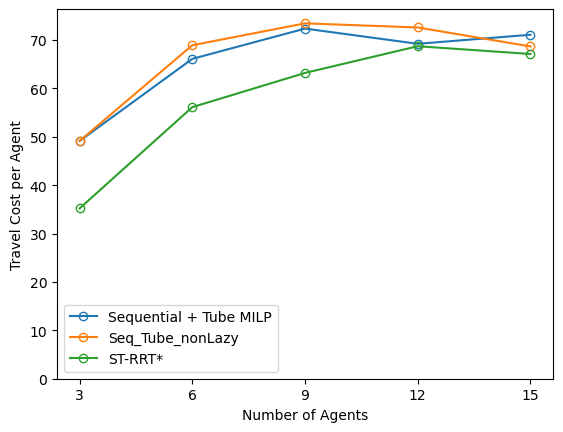

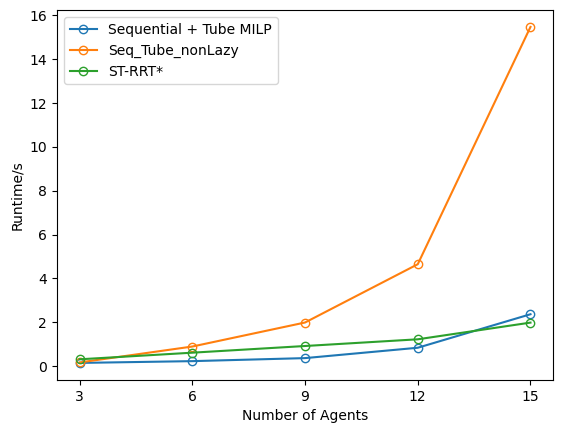

Room


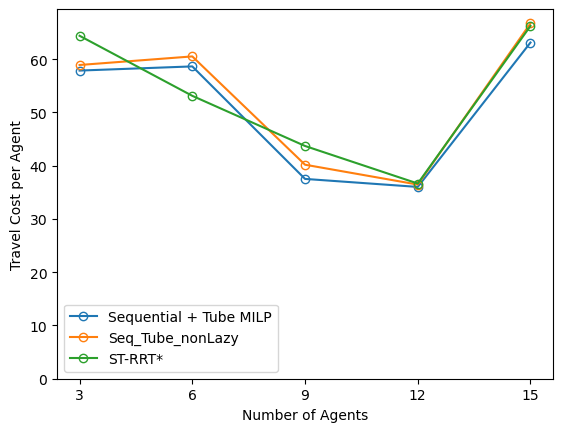

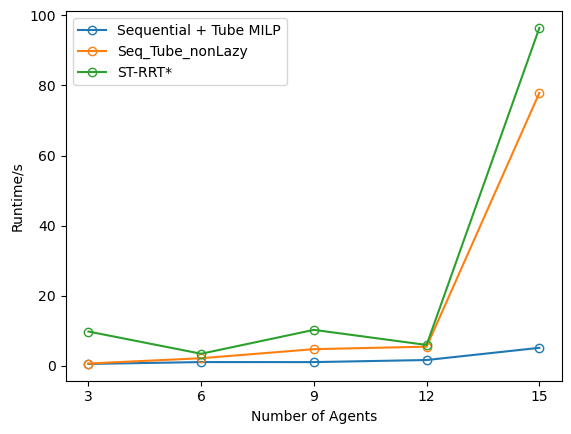

In [29]:
import os
env_names = ["MultiTunnel","SingleTunnel", "Warehouse", "Room"]

for env_name in env_names:
    print(env_name)
    # Make the figure saving folder
    if env_name not in os.listdir('./figures'):
        os.mkdir("./figures/"+env_name)

    # Load data
    with open("./data/{}.pkl".format(env_name),'rb') as fp:
        results = pkl.load(fp)
        results = results['results']


    TIMEOUT = 100
    # Visualize the simulation results
    metrics = {
            #     "Makespan": lambda result: [makespan(result['plan'])] if result['plan'] else [],
            #    "Flowtime": lambda result: [flowtime(result['plan'])] if result['plan'] else [],
            "Compute Time": lambda result: [result['time']] if \
                                                            'plan' in result\
                                                            and result['plan'] is not None\
                                                            and all([p is not None for p in result['plan']])\
                                                                else [],
            #    "Throuput per 60s": lambda result: [result['N_agent']/makespan(result['plan']) * 60]  if result['plan'] else [],
            "Ave. Travel Cost": lambda result: [flowtime(result['plan'])/result['N_agent']] if\
                                                 'plan' in result \
                                                 and result['plan'] is not None\
                                                and all([p is not None for p in result['plan']]) else []
            }

    legends = {
        "PIBT":"Hybrid Graph + PIBT",
        "S2M2": "S2M2",
        "PBS_Tube": "PBS + Tube MILP",
        "TAHP": "Hybrid Graph + MILP",
        "Seq_Tube": "Sequential + Tube MILP",
        "Seq_Temp_Obs": "Sequential + Simple MILP"
    }

    noplot = {"Seq_S2M2"}
    # noplot = {}

    # n_to_display = np.arange(2,21,2)
    # n_to_display = [10,20,30,40,50,60,70,80,90,100]
    n_to_display = [3,6,9,12,15]
    # n_to_display = np.arange(1,16)

    performance = {}

    for result in results:
        # print(result['plan'][-1])
        alg = result['alg_name']

        if alg not in performance:
            performance[alg] = {}
            performance[alg]['n_agents'] = []

        N = result['N_agent']

        if N not in n_to_display:
            continue
        
        performance[alg]['n_agents'].append(result['N_agent'])

        for metric, eval in metrics.items():
            if metric not in performance[alg]:
                performance[alg][metric] = []
            
            performance[alg][metric]+=eval(result)
    from matplotlib import pyplot as plt

    # Travel Cost per Agent
    metric = "Ave. Travel Cost"
    plt.figure()
    plt.ylabel("Travel Cost per Agent")
    plt.xlabel("Number of Agents")
    ymax = 0
    xticks = set()
    for alg in performance:
        if alg in noplot:
            continue
        x = performance[alg]['n_agents']
        val = performance[alg][metric]

        l = min(len(x),len(val))
        if l>0:
            plt.plot(x[:l],val[:l], label = legends[alg] if alg in legends else alg, marker = "o",markerfacecolor= 'none')
            xticks.update(x[:l])
            ymax = max(ymax,max(val[:l]))



    plt.xticks(list(xticks))
    plt.ylim(0.0,ymax*1.04)
    plt.legend()
    plt.savefig("./figures/"+env_name+"/TravelCost.pdf")
    plt.show()


    # Computational Time
    metric = "Compute Time"
    plt.figure()
    plt.ylabel("Runtime/s")
    plt.xlabel("Number of Agents")
    xticks = set()
    for alg in performance:
        if alg in noplot:
            continue

        x = performance[alg]['n_agents']
        val = performance[alg][metric]
        
        l = min(len(x),len(val))
        if l>0:
            plt.plot(x[:l],val[:l], label = legends[alg] if alg in legends else alg, marker = "o",markerfacecolor= 'none')
            xticks.update(x[:l])

    plt.xticks(list(xticks))

    ymax = TIMEOUT        
    # plt.ylim(0.0,ymax*1.0)
    plt.legend()
    plt.savefig("./figures/"+env_name+"/Runtime.pdf")
    plt.show()



In [ ]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 0.1

pos = []
for cp in continuous_plans:
    _,xs = interpolate_positions(*cp,interp_dt)
    pos.append(xs)

anim = animation(HG.env, pos, bloating_r=0.5, dt = interp_dt / 4)
anim.save("./figures/"+env_name+"/demo.mp4")
anim.save("./figures/"+env_name+"/demo.gif")
plt.close()   # Avoid plotting an extra figure.